# `model_inference.ipynb`

### Import các thư viện cần thiết

In [24]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
import sys
# Thêm thư mục chứa scripts vào sys.path
scripts_path = r"C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\scripts"
sys.path.append(scripts_path)
# Thử import class TradingEnv từ scripts.environment
from environment import TradingEnv
import MetaTrader5 as mt5
import ta

### Đường dẫn đến mô hình đã huấn luyện

In [25]:
model_path = r"C:\Users\nguye\OneDrive\documents\python\trading_bot_rl_ppo\models\ppo_trading_xauusd.zip"

### Khởi tạo kết nối với MetaTrader5

In [26]:
if not mt5.initialize():
    print("Lỗi khi khởi động MetaTrader5")
    mt5.shutdown()

### Lấy dữ liệu thời gian thực từ MetaTrader5

In [27]:
def fetch_real_time_data(symbol, n_bars=1000):
    """Lấy dữ liệu thời gian thực từ MetaTrader5."""
    rates = mt5.copy_rates_from_pos(symbol, mt5.TIMEFRAME_M1, 0, n_bars)
    if rates is None or len(rates) == 0:
        raise ValueError("Không thể lấy dữ liệu thời gian thực.")
    data = pd.DataFrame(rates)
    data['time'] = pd.to_datetime(data['time'], unit='s')
    data.rename(columns={"time": "datetime", "tick_volume": "volume"}, inplace=True)
    return data[['datetime', 'open', 'high', 'low', 'close', 'volume']]

### Tải mô hình PPO đã huấn luyện


In [28]:
if os.path.exists(model_path):
    model = PPO.load(model_path)
    print("Mô hình đã được tải thành công!")
else:
    raise FileNotFoundError(f"Mô hình không tồn tại tại: {model_path}")

Mô hình đã được tải thành công!


### Lấy dữ liệu thời gian thực

In [29]:
symbol = "XAUUSDm"  # Ví dụ sử dụng XAU/USD
real_time_data = fetch_real_time_data(symbol)

# Tiền xử lý dữ liệu để tính chỉ báo kỹ thuật

In [30]:
def preprocess_real_time_data(data):
    """Tiền xử lý dữ liệu thời gian thực để thêm các chỉ báo kỹ thuật."""
    data['rsi'] = ta.momentum.RSIIndicator(data['close'], window=14).rsi()
    macd = ta.trend.MACD(data['close'])
    data['macd'] = macd.macd()
    data['macd_signal'] = macd.macd_signal()
    data['macd_hist'] = macd.macd_diff()
    data['ema10'] = ta.trend.EMAIndicator(data['close'], window=10).ema_indicator()
    data['ema20'] = ta.trend.EMAIndicator(data['close'], window=20).ema_indicator()
    data['ema50'] = ta.trend.EMAIndicator(data['close'], window=50).ema_indicator()
    data = combined_trend(data)
    return data.dropna()


def calculate_dmi(data, period=14):
    # Tính True Range (TR)
    data['high_diff'] = data['high'].diff()
    data['low_diff'] = data['low'].diff()
    data['tr'] = data[['high_diff', 'low_diff', 'close']].max(axis=1).fillna(0)
    
    # Tính +DI và -DI
    data['c_DM'] = np.where((data['high_diff'] > data['low_diff']) & (data['high_diff'] > 0), data['high_diff'], 0)
    data['t_DM'] = np.where((data['low_diff'] > data['high_diff']) & (data['low_diff'] > 0), data['low_diff'], 0)
    
    # Tính toán các chỉ số cần thiết
    data['TR14'] = data['tr'].rolling(window=period).mean()
    data['c_DM14'] = data['c_DM'].rolling(window=period).mean()
    data['t_DM14'] = data['t_DM'].rolling(window=period).mean()
    
    data['c_DI'] = (data['c_DM14'] / data['TR14']) * 100
    data['t_DI'] = (data['t_DM14'] / data['TR14']) * 100

    return data


def combined_trend(data):
    # Tính ADX
    adx_period = 14  
    data['ADX'] = ta.trend.ADXIndicator(high=data['high'], low=data['low'], close=data['close'], window=adx_period).adx()

    # Tính DMI
    data = calculate_dmi(data, period=adx_period)

    # Khởi tạo cột Trend
    data['Trend'] = 'No Trend'
    
    # Đánh dấu xu hướng tăng
    data.loc[
        (data['ADX'] > 25) & 
        (data['c_DI'] > data['t_DI']) & 
        (data['macd'] > data['macd_signal']) & 
        (data['rsi'] < 70),
        'Trend'
    ] = 'Uptrend'

    # Đánh dấu xu hướng giảm
    data.loc[
        (data['ADX'] > 25) & 
        (data['t_DI'] > data['c_DI']) & 
        (data['macd'] < data['macd_signal']) & 
        (data['rsi'] > 30),
        'Trend'
    ] = 'Downtrend'

    # Xu hướng không rõ
    data.loc[data['ADX'] < 25, 'Trend'] = 'Sideways'

    return data

real_time_data = preprocess_real_time_data(real_time_data)

### Tạo môi trường với dữ liệu thời gian thực

In [31]:
env = DummyVecEnv([lambda: TradingEnv(real_time_data)])

### Dự đoán hành động từ mô hình

In [32]:
obs = env.reset()
actions = []
rewards = []
for _ in range(len(real_time_data)):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, infor = env.step(action)
    actions.append(action)
    rewards.append(reward)
    if done:
        break


### Hiển thị kết quả

In [33]:
def align_lengths(df, actions, rewards):
    length_diff = len(df) - len(actions)
    if length_diff > 0:
        actions += [np.nan] * length_diff
        rewards += [np.nan] * length_diff
    elif length_diff < 0:
        df = df.iloc[:len(actions)]
    return df, actions, rewards

real_time_data, actions, rewards = align_lengths(real_time_data, actions, rewards)
real_time_data['action'] = actions
real_time_data['reward'] = rewards


print(real_time_data[['datetime', 'close', 'action', 'reward']])

               datetime     close action  reward
49  2024-12-09 17:57:00  2664.557    [2]   [0.0]
50  2024-12-09 17:58:00  2664.669    [2]   [0.0]
51  2024-12-09 17:59:00  2664.500    [2]   [0.0]
52  2024-12-09 18:00:00  2663.859    [2]   [0.0]
53  2024-12-09 18:01:00  2663.809    [2]  [-0.5]
..                  ...       ...    ...     ...
995 2024-12-10 10:46:00  2673.936    [2]  [-0.5]
996 2024-12-10 10:47:00  2674.438    [2]  [-0.5]
997 2024-12-10 10:48:00  2674.182    [2]  [-0.5]
998 2024-12-10 10:49:00  2675.152    [2]  [-0.5]
999 2024-12-10 10:50:00  2675.176    NaN     NaN

[951 rows x 4 columns]


### Trực quan hóa hành động

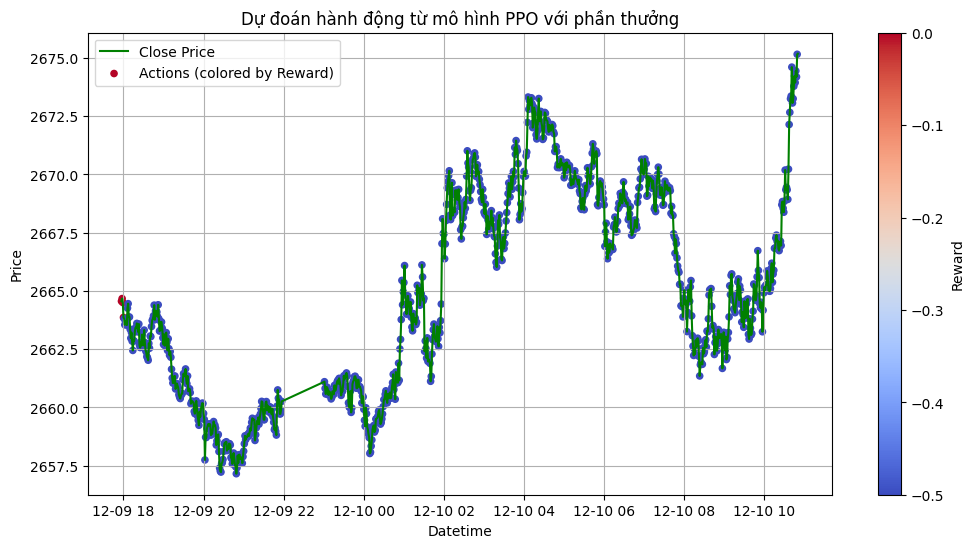

In [41]:
plt.figure(figsize=(12, 6))

# Vẽ giá đóng cửa
plt.plot(real_time_data['datetime'], real_time_data['close'], label="Close Price", color='green')

# Vẽ hành động với kích thước hoặc màu dựa trên reward
scatter = plt.scatter(
    real_time_data['datetime'], 
    real_time_data['close'], 
    c=real_time_data['reward'],  # Sử dụng phần thưởng để tạo màu sắc
    cmap='coolwarm',             # Sử dụng colormap để biểu diễn giá trị reward
    s=20,                        # Kích thước điểm cố định
    label="Actions (colored by Reward)"
)

# Thêm colorbar để biểu diễn giá trị reward
plt.colorbar(scatter, label="Reward")

# Thiết lập thông tin biểu đồ
plt.xlabel("Datetime")
plt.ylabel("Price")
plt.title("Dự đoán hành động từ mô hình PPO với phần thưởng")
plt.legend()
plt.grid(True)
plt.show()


### Ngắt kết nối MetaTrader5

In [35]:
mt5.shutdown()

True